In [1]:
import numpy as np 
import pandas as pd 
import datetime 
import pickle
import os
import time
import sys
from collections import OrderedDict
from datetime import timedelta

from RoZeroTools.ro_utils import load_JHU_deaths, make_infect_to_death_pmf, plot_shaded, Policy_Stats
from RoZeroTools.infection_series_estimator import InfectionSeriesEstimator

%matplotlib inline
import matplotlib.pyplot as plt  
import seaborn as sns

In [2]:
########################################
###        HELPER FUNCTIONS      #######
########################################
def simple_smoother( s, window_size = 5):
    
    neg_idxs = [ i for i in range(len(s)) if s.iloc[i] < 0 ]
    if not neg_idxs:
        return s, False
    else:
        for i in neg_idxs:
            var_later = np.std(s.iloc[i+1:i+1+window_size].values )/ np.mean(s.iloc[i+1:i+1+window_size].values )
            var_earlier = np.std(s.iloc[i-window_size:i].values )/  np.mean(s.iloc[i-window_size:i].values )
            if var_later > var_earlier:  
                interval = (i, i+window_size+1) 
                tot = s.iloc[interval[0]: interval[1]].sum()
                s.iloc[i] = tot/ (window_size + 1)
                s.iloc[interval[0]+1:interval[1]] =(window_size/(window_size+1))*tot*( 
                                                        s.iloc[interval[0]+1:interval[1]]/(s.iloc[interval[0]+1:interval[1]].sum() ) )
            else:
                interval = (i - window_size, i+1 )
                tot = s.iloc[interval[0]: interval[1]].sum()
                s.iloc[i] = tot/ (window_size + 1)
                s.iloc[interval[0]:interval[1]-1] =(window_size/(window_size+1))*tot*( 
                                                        s.iloc[interval[0]:interval[1]-1]/(s.iloc[interval[0]:interval[1]-1].sum() ) )
        return s.astype(int), True
    

In [3]:
JHU_deaths = load_JHU_deaths()
policies = pd.read_csv("../data/state_policy.csv" ,  header =0, index_col = 0) 

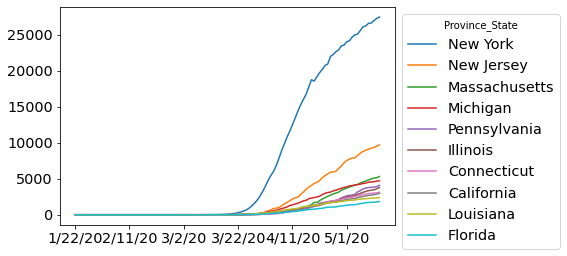

In [4]:
state_top_cas = list(JHU_deaths.iloc[:,-1].sort_values()[::-1].index[0:10])

ax = JHU_deaths.loc[state_top_cas, : ].transpose().plot()
leg = ax.get_legend()
leg.set_bbox_to_anchor( (1, 1), )

In [5]:
deaths_by_day = pd.DataFrame( index = pd.to_datetime(JHU_deaths.columns[1:]), columns = state_top_cas)
is_smoothed = pd.Series(index =state_top_cas, data = False, dtype = bool )

for state in state_top_cas:
    deaths_by_day_state =  JHU_deaths.loc[state,:].diff().dropna()
    deaths_by_day_state_smooth, smoothed = simple_smoother( deaths_by_day_state.copy(), window_size = 7)
    deaths_by_day.loc[:, state] = deaths_by_day_state_smooth.values
    is_smoothed.loc[state] = smoothed
display(is_smoothed)

New York          True
New Jersey       False
Massachusetts    False
Michigan         False
Pennsylvania     False
Illinois         False
Connecticut      False
California        True
Louisiana        False
Florida          False
dtype: bool

Text(0, 0.5, 'Deaths by day\n(scaled by maximum)')

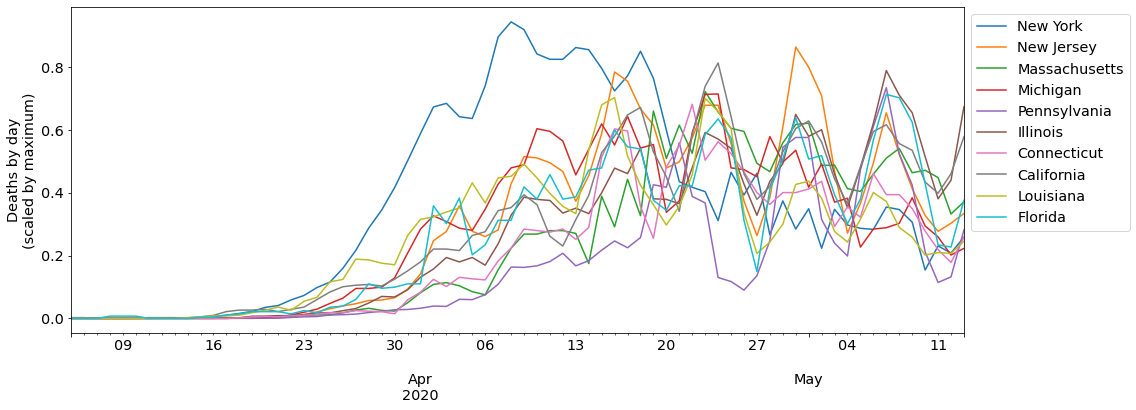

In [6]:
fig , ax = plt.subplots(figsize= (16,6))
ax = deaths_by_day.divide(deaths_by_day.max(axis = 0), axis = 1).rolling(3,).mean().loc['2020-03-05':].plot(ax = ax)
leg = ax.get_legend()
leg.set_bbox_to_anchor( (1, 1), )
ax.set_ylabel("Deaths by day\n(scaled by maximum)")

In [9]:
## Parameters
T_period = (1,8)
draws =  500
chains = 2
mu = 13.
policy_factor = 0.01

## Set up directories for storing ouput
time = datetime.datetime.isoformat(datetime.datetime.now() ).split(".")[0]
models_dir = os.path.join( "models", str(time) )
preds_dir = os.path.join( "predictions", str(time) )

os.makedirs(models_dir , exist_ok = True)
os.makedirs(preds_dir, exist_ok = True)

## Do estimation and write results
for state in state_top_cas:
    print("Working on {}".format(state))
    policy_dates =   [x for x in policies[state].dropna().unique() ]
    ise = InfectionSeriesEstimator(event_series =deaths_by_day[state].copy().astype(int), 
                                     P_e_given_i= make_infect_to_death_pmf(), 
                                     T_period = T_period,
                                     policy_dates= policy_dates )
    p_i, Re, p_i_samples, Re_samples= ise.fit(mu = mu,
                                              policy_factor = policy_factor, 
                                              draws = draws ,
                                              chains = chains )
    
    df_samples = pd.concat( [p_i_samples ,Re_samples], axis = 1, keys = ["p_i", "Re"] )
    df_samples.to_csv( os.path.join(preds_dir , "{}_samples.csv".format(state)) )
    df_cinterval =  pd.concat( [p_i , Re] , axis = 1, keys = ["p_i", "Re"] )
    df_cinterval.to_csv( os.path.join(preds_dir , "{}_intervals.csv".format(state)) )
    
    f = open(os.path.join(models_dir, "{}.pkl".format(state)) , 'wb' )
    pickle.dump(ise , f)
    f.close()
    
##  Combine results
df_samples_list = [ pd.read_csv( os.path.join(preds_dir,"{}_samples.csv".format(state)), index_col=0 , header = [0,1] ) 
                                    for state in list(state_top_cas )  ]
df_samples = pd.concat(df_samples_list, axis = 1, keys = list(state_top_cas ) )
df_samples.index = pd.to_datetime(df_samples.index)
df_samples.to_csv( os.path.join(preds_dir,"samples.csv" ) )
for state in state_top_cas:
    os.remove(os.path.join(preds_dir,"{}_samples.csv".format(state)) )
    
df_cintervals_list = [ pd.read_csv( os.path.join(preds_dir,"{}_intervals.csv".format(state)), index_col=0 , header = [0,1] ) 
                                    for state in list(state_top_cas )  ]
df_cintervals = pd.concat(df_cintervals_list, axis = 1, keys = list(state_top_cas) )
df_cintervals.to_csv(os.path.join(preds_dir,"intervals.csv" ) )
df_cintervals.index = pd.to_datetime(df_cintervals.index)
for state in state_top_cas:
    os.remove(os.path.join(preds_dir,"{}_intervals.csv".format(state)) )

Working on New York


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (2 chains in 1 job)
NUTS: [p_i]
Sampling chain 1, 0 divergences: 100%|██████████| 1000/1000 [00:10<00:00, 94.42it/s]


Working on New Jersey


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (2 chains in 1 job)
NUTS: [p_i]
Sampling chain 1, 0 divergences: 100%|██████████| 1000/1000 [00:11<00:00, 89.11it/s]


Working on Massachusetts


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (2 chains in 1 job)
NUTS: [p_i]
Sampling chain 1, 0 divergences: 100%|██████████| 1000/1000 [00:09<00:00, 105.28it/s]


Working on Michigan


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (2 chains in 1 job)
NUTS: [p_i]
Sampling chain 1, 0 divergences: 100%|██████████| 1000/1000 [00:09<00:00, 100.07it/s]


Working on Pennsylvania


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (2 chains in 1 job)
NUTS: [p_i]
Sampling chain 1, 0 divergences: 100%|██████████| 1000/1000 [00:10<00:00, 97.73it/s]


Working on Illinois


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (2 chains in 1 job)
NUTS: [p_i]
Sampling chain 1, 0 divergences: 100%|██████████| 1000/1000 [00:09<00:00, 100.85it/s]


Working on Connecticut


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (2 chains in 1 job)
NUTS: [p_i]
Sampling chain 1, 0 divergences: 100%|██████████| 1000/1000 [00:09<00:00, 102.96it/s]


Working on California


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (2 chains in 1 job)
NUTS: [p_i]
Sampling chain 1, 0 divergences: 100%|██████████| 1000/1000 [00:10<00:00, 93.81it/s]


Working on Louisiana


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (2 chains in 1 job)
NUTS: [p_i]
Sampling chain 1, 0 divergences: 100%|██████████| 1000/1000 [00:12<00:00, 80.44it/s]


Working on Florida


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (2 chains in 1 job)
NUTS: [p_i]
Sampling chain 1, 0 divergences: 100%|██████████| 1000/1000 [00:11<00:00, 83.58it/s]


## Check fits to casualties-by-day data

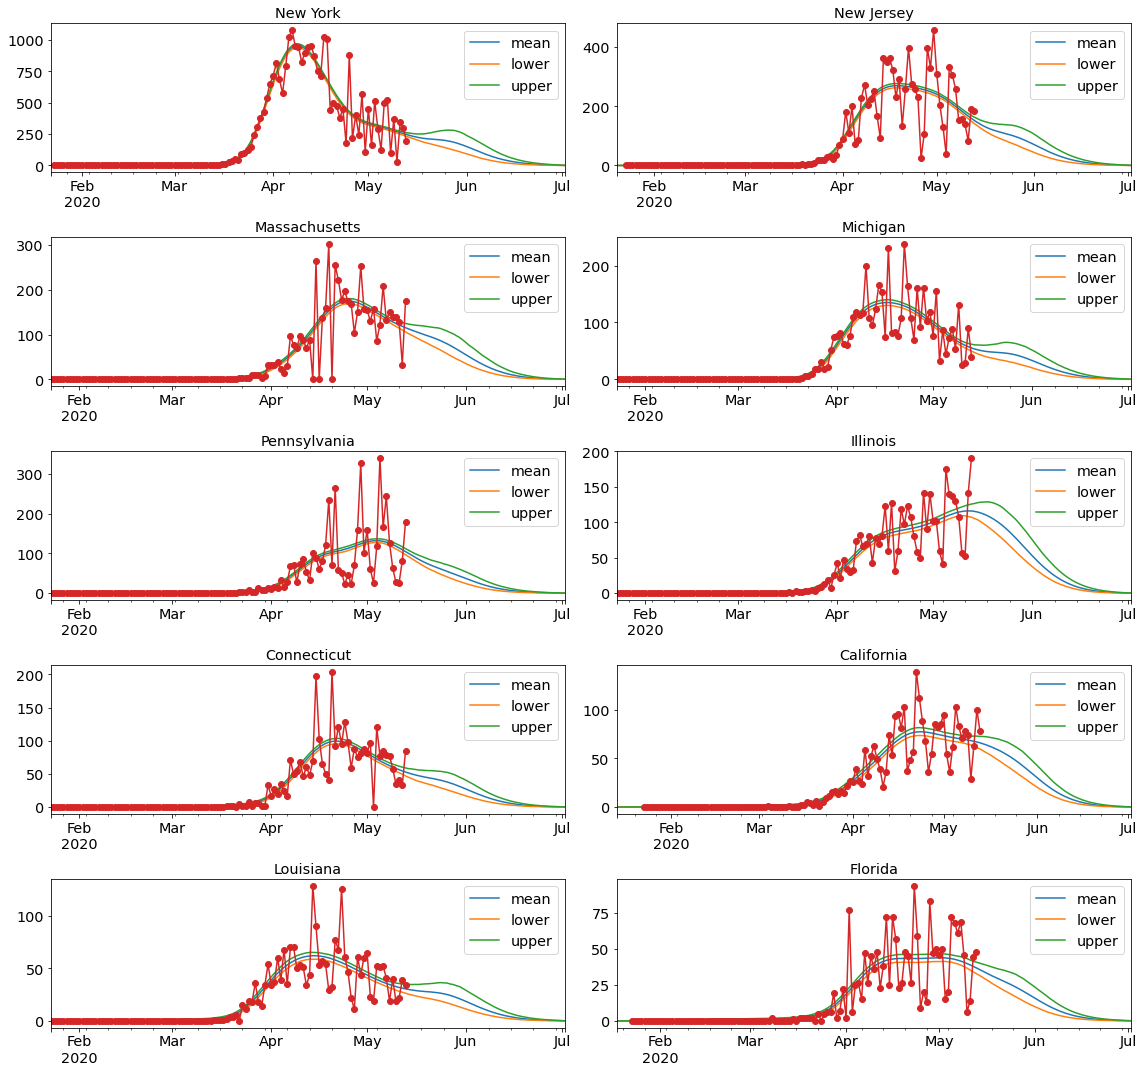

In [8]:
ncols = 2
models_dir =  "./models/2020-05-14T13:45:31/" ##models_dir
nrows = -(-len(state_top_cas)//2)
f_out = "./figures/predicted_mean_deaths_by_day.png"

fig , axes = plt.subplots(nrows = nrows, ncols = ncols ,figsize = (16,3*nrows))
axes = np.ravel(axes)

for state, ax in zip(state_top_cas, axes) :
    f = open( os.path.join(models_dir, "{}.pkl".format(state) ) , 'rb')
    ise = pickle.load(f)
    f.close()
    (ise.predict_p_e()[2]).plot(ax = ax)
    deaths_by_day[state].plot(marker = "o", ax = ax)
    ax.set_title(state)
    
fig.tight_layout()

if not os.path.isdir(os.path.dirname(f_out)):
    os.makedirs(os.path.dirname(f_out))
fig.savefig(f_out, dpi = 200, bbox_inches = "tight")

## Plot fraction of total infections by day and $R_e$, the effective reproduction number

In [11]:
## Load data
preditions_dir =  "./predictions/2020-05-14T13:45:31/" # preds_dir ## Change this to match the folder created during execution of estimation cell 
df_cintervals = pd.read_csv(os.path.join(preditions_dir, "intervals.csv"), header = [0,1,2], index_col = 0)

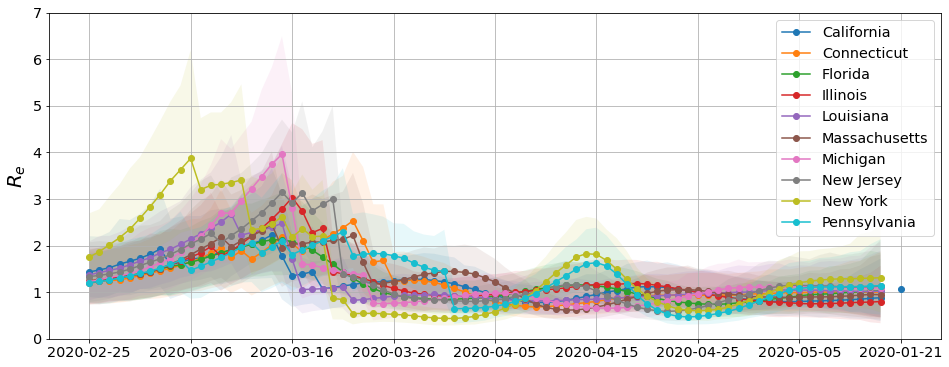

In [14]:
fig = plot_shaded(df_cintervals.loc[ '2020-02-25': ,(slice(None), "Re") ].droplevel(axis = 1,level =1),
                  alpha = 0.1, figsize= (16,6))
ax = fig.get_axes()[0]
ax.set_ylim((0 , 7) )
ax.grid(True)
leg = ax.get_legend()
leg.set_bbox_to_anchor((1,1))
ax.set_ylabel(r'$R_e$', fontsize = 20)

f_out = "./figures/Re_predicted.png"
if not os.path.isdir(os.path.dirname(f_out)):
    os.makedirs(os.path.dirname(f_out))
fig.savefig(f_out, dpi = 200, bbox_inches = "tight")

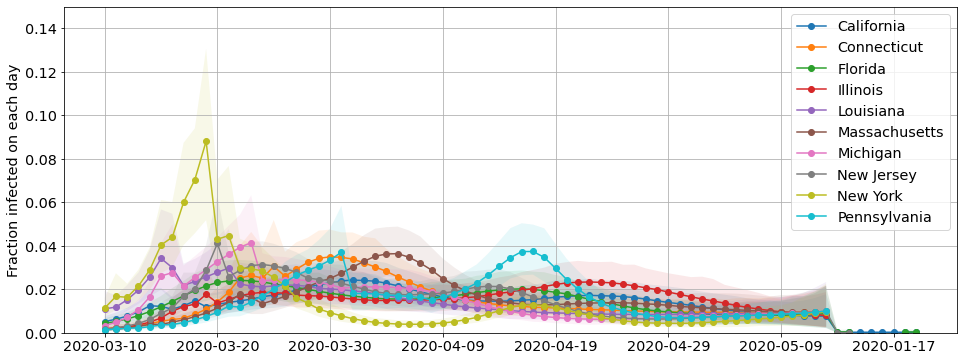

In [15]:
fig = plot_shaded(df_cintervals.loc[ '2020-03-10': ,(slice(None), "p_i") ].droplevel(axis = 1,level =1),
                                           alpha = 0.1,figsize = (16,6))
ax = fig.get_axes()[0]
ax.set_ylim((0 , 0.15) )
ax.grid(True)
leg = ax.get_legend()
leg.set_bbox_to_anchor((1,1))
ax.set_ylabel('Fraction infected on each day')

f_out = "./figures/fraction_infected.png"
if not os.path.isdir(os.path.dirname(f_out)):
    os.makedirs(os.path.dirname(f_out))
fig.savefig(f_out, dpi = 200, bbox_inches = "tight")

In [17]:
## File names
preditions_dir =  "./predictions/2020-05-14T13:45:31/" ##preds_dir ## Change this to match the folder created during execution of estimation cell 
fname_policies = "../data/state_policy.csv"

## Load Data
df_samples = pd.read_csv( os.path.join(preditions_dir, "samples.csv"), index_col = 0, header=[0,1,2] )
df_samples.index = [pd.Timestamp(x) for x in df_samples.index]
ro_samples = df_samples.loc[ : , (slice(None), "Re")].copy().droplevel(axis=1,  level = 1)
ro_samples_grouped = ro_samples.groupby(axis = 1, level = 0 )
policies = pd.read_csv(fname_policies ,  header =0, index_col = 0)

## Create policy_stats object
policy_stats = Policy_Stats(policies)
pct_change_interval, pct_change_samples = policy_stats.est_pct_change( 
                                                {state:  df.droplevel(axis =1 , level = 0) for state, df in ro_samples_grouped}, 
                                                policies =None)

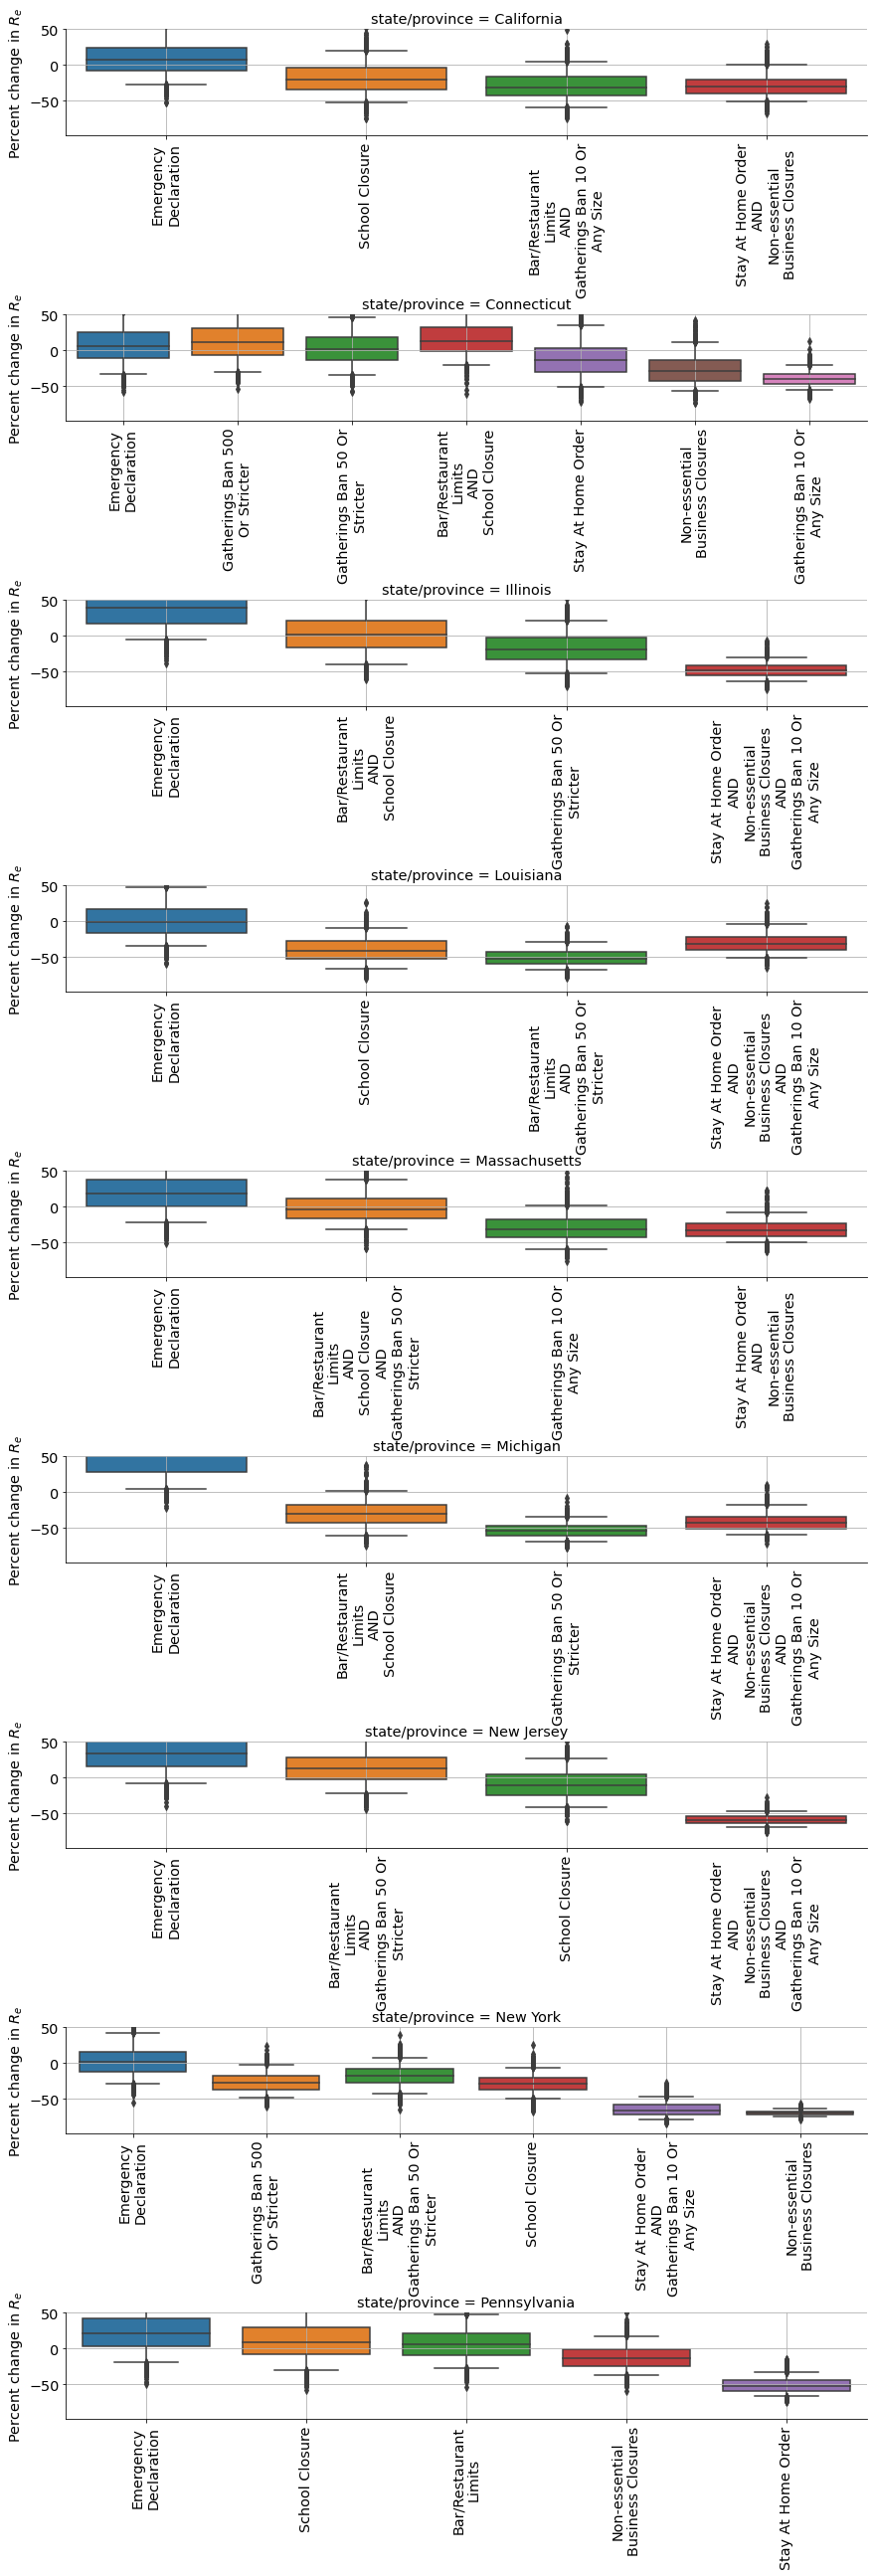

In [20]:
## Plot changes in Ro grouped by state
fig = policy_stats.boxplot_changes_by_state(policies =None, aspect = 3, height = 4, hspace=1.7)

f_out = "./figures/percent_change_Re_by_state.png"
if not os.path.isdir(os.path.dirname(f_out)):
    os.makedirs(os.path.dirname(f_out))
fig.savefig(f_out, dpi = 200, bbox_inches = "tight")

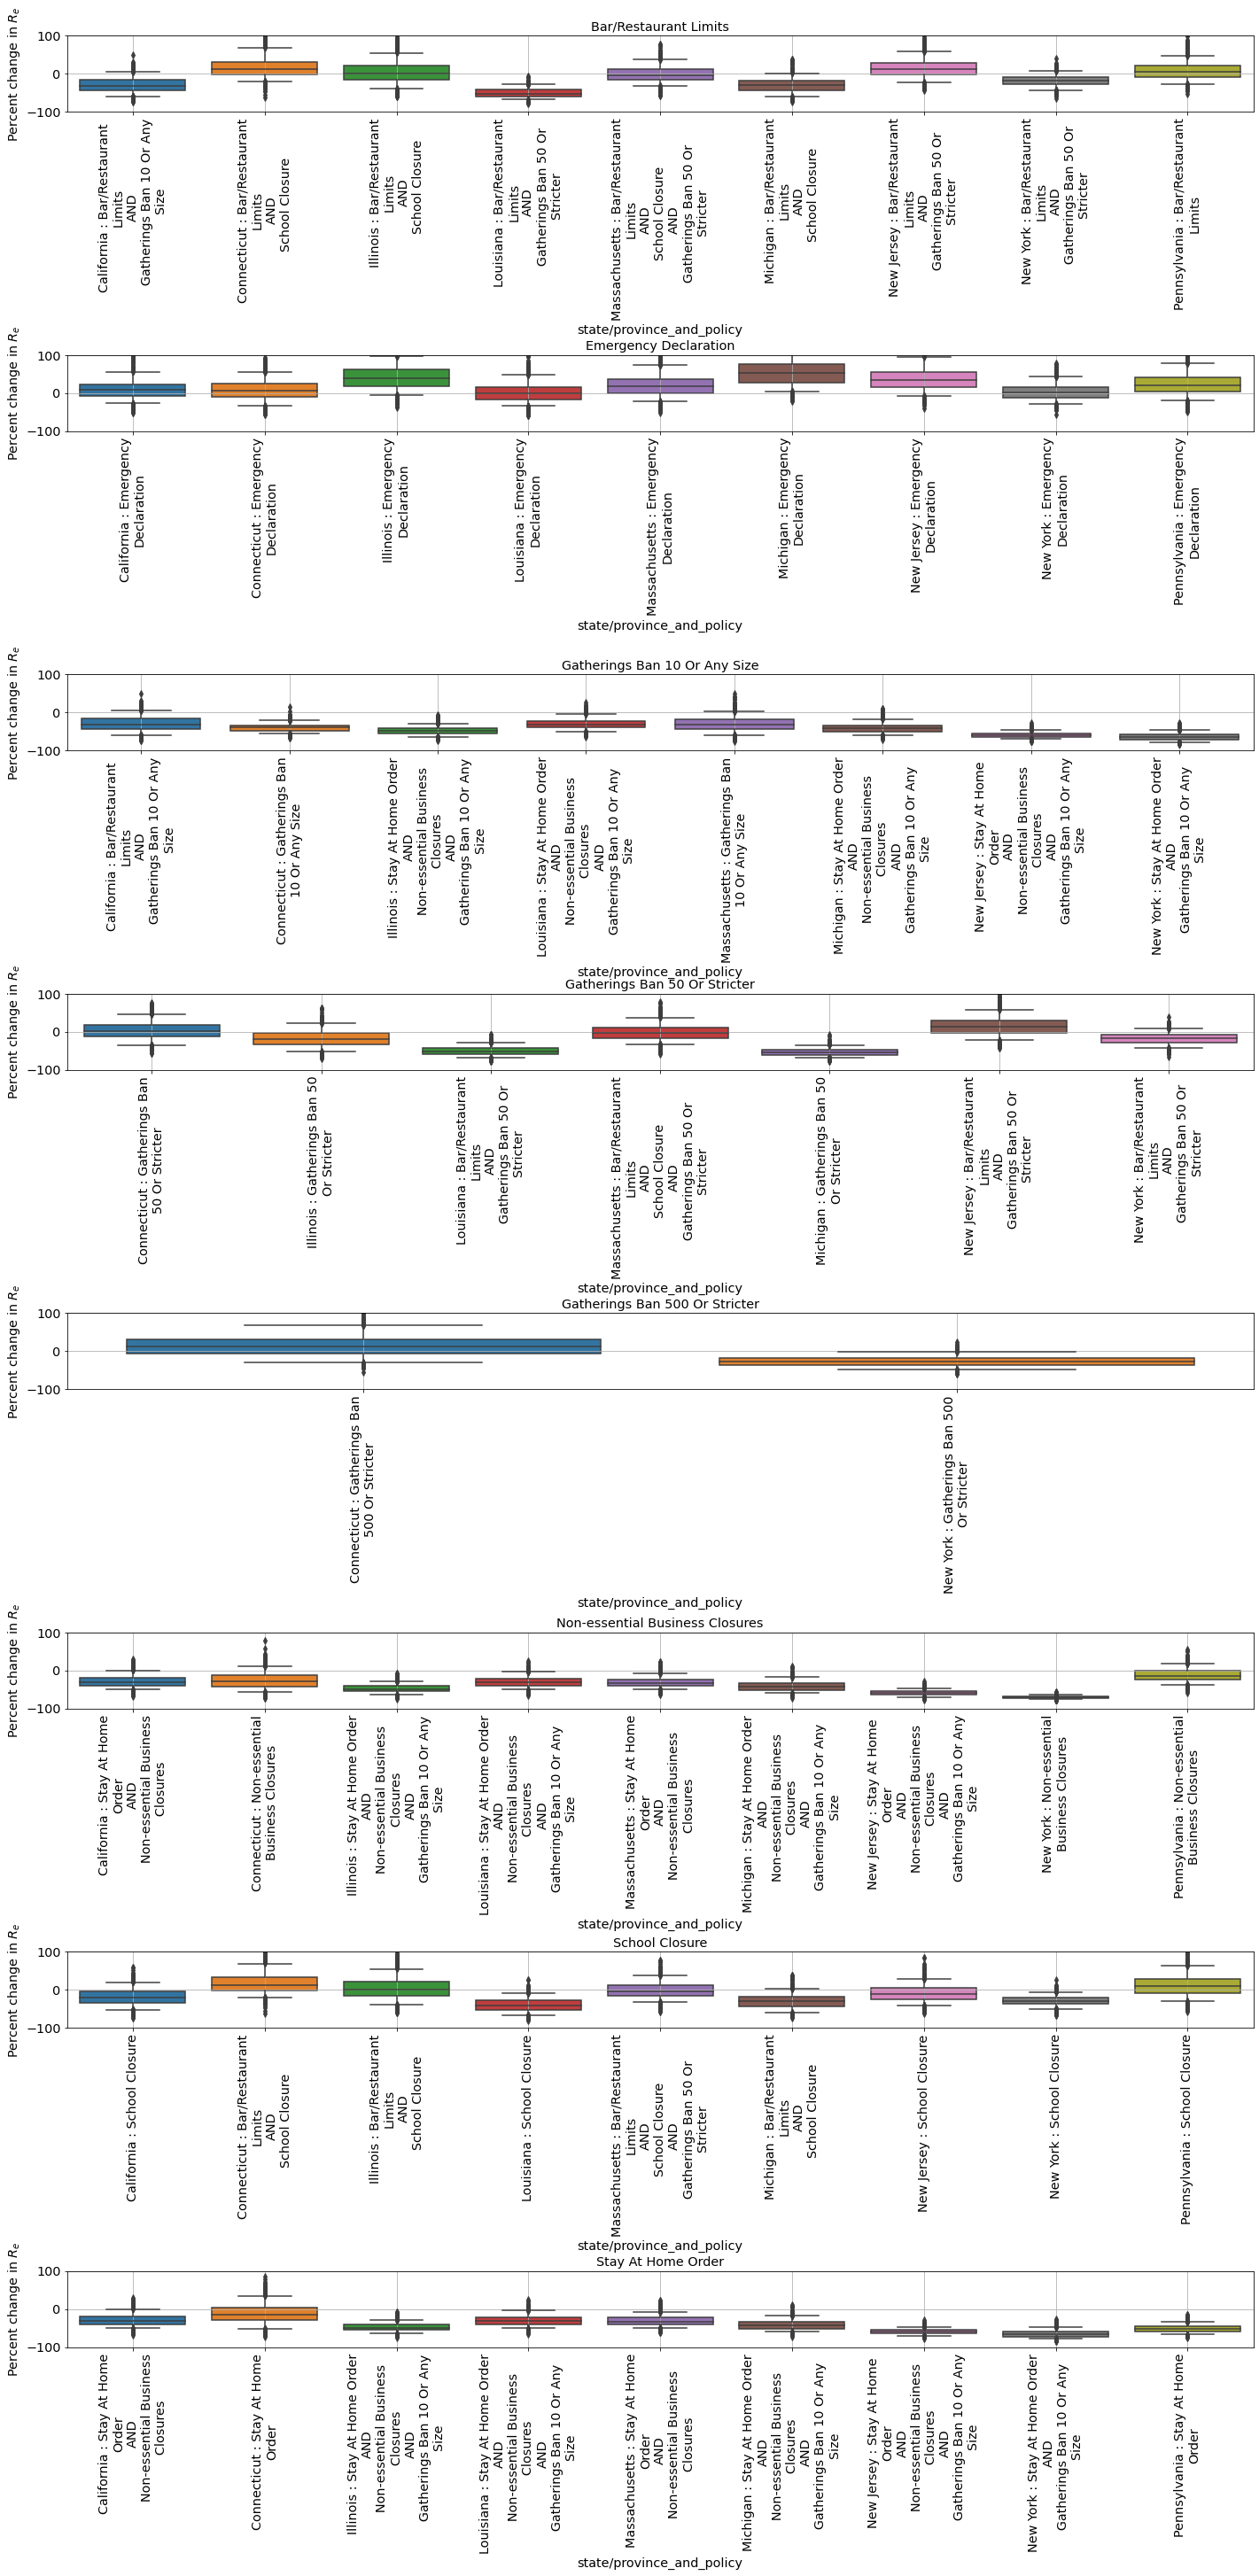

In [21]:
## Plot changes in Ro groups by policy
fig = policy_stats.boxplot_changes_by_policy(aspect = 4, height = 6,y_lim = (-100, 100), hspace = 3.2)

f_out = "./figures/percent_change_Re_by_policy.png"
if not os.path.isdir(os.path.dirname(f_out)):
    os.makedirs(os.path.dirname(f_out))
fig.savefig(f_out, dpi = 200, bbox_inches = "tight")